# 1. Bacteria Influencing Corrosion
This notebook aims to identify microorganisms that have a recognized influence on corrosion damage. The analysis involves comparing bacteria against known corrosion-related gene sequences and metabolic pathways associated with Microbiologically Influenced Corrosion (MIC).
__Aims__
To search literature on the different selected groups of genera, using different terms. Make a comprehensive tabel of the results. Comprehensive search on specific functional genes involved in corrosion processes, focusing on: Sulfate reduction pathways (dsrAB, aprAB genes),metal reduction genes and cytochrome c3 complexes.
Perform targeted analysis between known corrosion-causing bacteria and newly identified bacterial specimens

__Databases Used__:
    * KEGG (Kyoto Encyclopedia of Genes and Genomes): https://www.genome.jp/kegg/pathway.html.Used for metabolic pathway identification and functional gene annotations  
    * PubMed: Used for literature analysis and validation.
__Analysis Workflow__    
1. Initial Computational Screening → Search KEGG database for pathways and genes →Literature validation through PubMed
2. Results Analysis and Documentation → Compilation of findings in Excel sheets → Documentation of references and abstracts
Notebook files  
Copy/home/beatriz/MIC/2_Micro/data_Ref/  
├── bacteria_corrosion_summary_{timestamp}.xlsx    # Results file for each run  
│   ├── Analysis_{timestamp}    # Main results sheet  
│   ├── References             # APA formatted references  
│   └── Abstracts             # Related paper abstracts  
└── Original_data/            # Raw data storage  

This notebook analyzes and compares three distinct bacterial groups:

The checked dataframe containing statistically significant genera, which reveals corrosion-specific patterns and includes both known and novel findings based on category progression
The core_taxa dataframe, comprising the 60 highest abundance taxa, which demonstrates fundamental community structure with abundance >20% across systems
The usual_taxa dataframe, containing bacteria historically associated with corrosion, which shows some overlap with core_taxa and checked_data, validating our selection approach

The checked dataframe encompasses features from categories 2 and 3 that are significant to corrosion, along with major players from category 1. Category 1 bacteria may serve protective roles, play important community functions, or act as bystanders. For example, phenylobacterium (549) presents an intriguing mechanism, showing strong statistical significance in relation to risk labels and high explained variance. Its inverse relationship with the risk label suggests it may be a pioneer species. These characteristics typically appear in freshwater/early stage systems with high oxygen environments. If correct, these systems would exhibit lower conductivity due to aromatic compounds' lower polarity compared to aliphatic compounds, resulting in reduced ion availability and fewer corrosion products. CopyRetryClaude does not have internet access. Links provided may not be accurate or up to date.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
# For Colab
'''from google.colab import drive  #silence for vscode
drive.mount('/content/drive')
#change the path
os.chdir('/content/drive/My Drive/MIC/data_Ref')
base_dir = Path("/content/drive/My Drive/MIC/data_Ref")
results_file = base_dir / "bacteria_corrosion_summary.xlsx"
results_file = base_dir / "bacteria_corrosion_summary_improved.xlsx"'''

# For colab
'''!pip install pandas numpy biopython
!pip install requests beautifulsoup4
!pip install Bio'''
# For VSCode
base_dir = Path("/home/beatriz/MIC/2_Micro/data_Ref")
original_dir = base_dir / "Original_data"
results_file = base_dir / "bacteria_corrosion_summary.xlsx"
results_file = base_dir / "bacteria_corrosion_summary_improved.xlsx"

# 2. Preparing data

In [2]:
from Bio import Entrez
from functools import partial
import requests
from bs4 import BeautifulSoup
import time
import urllib3
from datetime import datetime
import logging
import openpyxl
from openpyxl.styles import Alignment
import gc #clutter
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from scholarly import scholarly  # For Google Scholar
from crossref.restful import Works  # For CrossRef

The dataframes can be run through the notebook by just changing the sheet_name all other left the same, so in this way we can be able to pass the individual df and make some previous analysis that allow to make better choices.

In [ ]:
# selected refer to each of the three dfs for practicality the name is replace only
'''selected = pd.read_excel("/home/beatriz/MIC/2_Micro/data/finalist_dfs.xlsx", sheet_name='one of the three df', header=[0,1,2,3,4,5,6,7])
selected
# Drop first row specifically (index 0 which contains NaNs)
selected = selected.drop(index=0)
# Drop first column (the index column with Level1, Level2, etc)
selected = selected.drop(selected.columns[0:3], axis=1)'''

In [ ]:
selected_list = selected.columns.get_level_values(6)
# Extract Genera and ID from the multi-index, For selected genera
selected_GID = dict(zip(selected.columns.get_level_values(6), selected.columns.get_level_values(7)))

# 3. Reference Formating Function
Following function is to take the references given in the search and present them on APA style list

In [ ]:
def format_apa_reference(article):
    """Format article data into APA style reference"""
    try:
        # Get authors
        if 'AuthorList' in article:
            authors = article['AuthorList']
            if len(authors) > 6:
                author_text = f"{authors[0]['LastName']}, {authors[0].get('ForeName', '')[0]}., et al."
            else:
                author_list = []
                for author in authors:
                    if 'ForeName' in author:
                        author_list.append(f"{author['LastName']}, {author['ForeName'][0]}.")
                    else:
                        author_list.append(f"{author['LastName']}")
                author_text = ", ".join(author_list[:-1]) + " & " + author_list[-1] if len(author_list) > 1 else author_list[0]
        else:
            author_text = "No author"

        # Get year
        pub_date = article['Journal']['JournalIssue']['PubDate']
        year = pub_date.get('Year', 'n.d.')

        # Get title
        title = article.get('ArticleTitle', 'No title')

        # Get journal info
        journal = article['Journal']
        journal_title = journal.get('Title', journal.get('ISOAbbreviation', 'No journal'))

        # Get volume, issue, pages
        volume = journal['JournalIssue'].get('Volume', '')
        issue = journal['JournalIssue'].get('Issue', '')
        pagination = article.get('Pagination', {}).get('MedlinePgn', '')

        # Format the reference
        reference = f"{author_text} ({year}). {title}. {journal_title}"
        if volume:
            reference += f", {volume}"
        if issue:
            reference += f"({issue})"
        if pagination:
            reference += f", {pagination}"
        reference += "."

        return reference
    except Exception as e:
        return f"Error formatting reference: {str(e)}"

# 4. Query DB: Searching Corrosion Genes
This function search on PubMed database the bacteria in the list for different criteria related to corrosion, in order to found which of the bacteria has been previouly identified as causing damage by corrosion. The funciton search various terms used in corrosion and metabolic pathways, then the literature_analysis is done.

In [ ]:
def search_corrosion_genes(bacteria_name, base_dir, gid_dict):
    """
This function searches for bacteria's involvement in corrosion processes through:
Literature search using specific corrosion-related terms
Analysis of metabolic pathways and genes related to corrosion

    Parameters:
    bacteria_name: str - name of the bacteria to search
    base_dir: Path - directory where the Excel file will be stored containing:
        - Main Analysis sheet: Complete table with columns Name, Metabolism, Hits etc
        - References sheet: Citations in APA format
        - Abstracts sheet: Full paper abstracts
    gid_dict: dict - mapping of bacteria names to their GIDs
    """
    # Get GID for this bacteria, so that we can identify with name and ID
    bacteria_gid = gid_dict.get(bacteria_name, f"NEW_{bacteria_name}")  # Use NEW_ prefix for new bacteria
    # Create a timestamped filename for this run
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    # Defining the results file within base_dir
    results_file = base_dir / f"bacteria_corrosion_summary.xlsx"

    # Add timing for individual bacteria
    bacteria_start_time = time.time()
    print(f"Starting search for {bacteria_name} at: {datetime.now().strftime('%H:%M:%S')}")

    results = {
        'bacteria': bacteria_name,
        'sulfate_reduction': False,
        'metal_reduction': False,
        'corrosion_associated': False,
        'cytochrome_c3': False,
        'acid_production': False,
        'biofilm_formation': False,
        'h2s_production': False,
        'literature_count': 0,
        'evidence': [],
        'processing_time': 0,
    }

    # Creating a structured record for each bacteria
    bacteria_record = {
        'Name': bacteria_name,      # Bacteria species/strain name
        'Metabolism': [],          # List of identified metabolic pathways
        'Terms': [],              # Search terms that yielded results
        'Hits': 0,               # Total number of relevant papers found
        'Best_Reference': '',    # Most relevant paper in APA format
        'Abstract': ''          # Abstract from key paper
    }

    try:
        # 1. Check KEGG for pathways and genes
        base_url = "http://rest.kegg.jp/" # Check for metabolic pathways and gene presence. Functional anotation.

    except Exception as e:
        print(f"KEGG API error for {bacteria_name}: {str(e)}")

        # retry strategy in case there is connectivity issues
        retry_strategy = Retry(
            total=3,
            backoff_factor=1,
            status_forcelist=[500, 502, 503, 504]
        )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session = requests.Session()
        session.mount("http://", adapter)
        session.mount("https://", adapter)
        # Using sessions no request
        pathway_response = session.get(f"{base_url}find/module/{bacteria_name}")
        pathway_text = pathway_response.text.lower()

        # Define search terms key metabolic processes related to corrosion
        sulfate_terms = [
                'sulfate', 'sulphate',    # Terms related to sulfate reduction pathway
                'dsrab', 'dsra', 'dsrb',  # Key genes in dissimilatory sulfate reduction
                'aprab', 'apra', 'aprb',  # Adenosine-5'-phosphosulfate reductase genes
                'sat',  # Sulfate adenylyltransferase
                'sox',  # Sulfur oxidation
                'sir',  # Sulfite reductase
                'aps'   # Adenosine phosphosulfate
        ]
        metal_terms = [
                'metal', 'iron', 'fe(iii)', 'metal deterioration', 'MIC',
                'cytochrome', 'corrosion', 'biocorrosion',
                'methane corrosion', 'methanogenesis corrosion',
                'bacteria corrosion', 'anaerobic corrosion',
                'biofilm corrosion', 'manganese corrosion',
                'denitrification corrosion',
                'mtr',  # Metal reduction
                'omc',  # Outer membrane cytochromes
                'pil',  # Pili genes involved in metal reduction
                'cymA',  # Cytoplasmic membrane protein
                'hydA',  # Hydrogenase
                'feo',  # Ferrous iron transport
                'nrf',   # Nitrite reduction
                'organic acid AND corrosion',
                'acid metabolite AND metal deterioration',
                'fermentation AND corrosion',
                'biofilm AND (corrosion OR MIC)',
                'hydrogen sulfide AND corrosion',
                'thiosulfate AND corrosion'
                ]

        # Check pathway text
        if any(term in pathway_text for term in sulfate_terms):
            # Verify pathway presence
            pathway_evidence = [term for term in sulfate_terms if term in pathway_text]
            if pathway_evidence:
                results['sulfate_reduction'] = True
                results['evidence'].append(f"Found sulfate pathway evidence: {pathway_evidence}")
            else:
                # Flag potential inconsistency
                print(f"Warning: {bacteria_name} shows sulfate reduction hits but no clear pathway evidence")

        if any(term in pathway_text for term in metal_terms):
            results['metal_reduction'] = True
            results['evidence'].append(f"Found metal pathway: {[term for term in metal_terms if term in pathway_text]}")

        # Look for genes
        genes_response = session.get(f"{base_url}find/genes/{bacteria_name}")
        genes_text = genes_response.text.lower()

        if "cytochrome c3" in genes_text:
            results['cytochrome_c3'] = True
            results['evidence'].append("Found cytochrome c3 gene")

        if any(gene in genes_text for gene in ['dsr', 'apr', 'sat']):
            results['sulfate_reduction'] = True
            results['evidence'].append(f"Found sulfate genes: {[gene for gene in ['dsr', 'apr', 'sat'] if gene in genes_text]}")

    except Exception as e:
        print(f"KEGG API error for {bacteria_name}: {str(e)}")

    # 3. Check literature
    try:
        Entrez.email = "beatrizamandawatts@gmail.com"

        search_terms = [
            f"{bacteria_name}[Organism] AND corrosion[Title]",
            f"{bacteria_name}[Organism] AND biocorrosion[Title]",
            f"{bacteria_name}[Organism] AND 'microbiologically influenced corrosion'[Title]",
            f"{bacteria_name}[Organism] AND (dsrAB OR aprAB) AND corrosion", # sulphate metabolism
            f"{bacteria_name}[Organism] AND (metal reduction OR iron reduction)",   # metal interaction
            f"{bacteria_name}[Organism] AND (cytochrome c3) AND corrosion",
            f"{bacteria_name}[Organism] AND corrosion",
            f"{bacteria_name}[Organism] AND biocorrosion",
            f"{bacteria_name}[Organism] AND (MIC OR 'microbiologically influenced corrosion')",
            f"{bacteria_name}[Organism] AND 'material deterioration'",
            f"{bacteria_name}[Organism] AND ('metal deterioration' OR 'metallic corrosion')",
            f"{bacteria_name}[Organism] AND (acid production) AND (corrosion OR 'metal deterioration' OR MIC)",
            f"{bacteria_name}[Organism] AND AND biofilm AND (corrosion OR MIC)",
            f"{bacteria_name}[Organism] AND (ochre formation OR iron oxide deposits OR rust formation)",
            f"{bacteria_name}[Organism] AND (hydrogen sulfide OR H2S) AND (corrosion OR 'metal deterioration')"
            f"{bacteria_name}[Organism] AND ('sulfate reducing bacteria'[Title/Abstract] AND corrosion)",
            f"{bacteria_name}[Organism] AND ('metal reducing bacteria'[Title/Abstract] AND corrosion)",
            ]

        for term in search_terms:
            handle = Entrez.esearch(db="pubmed", term=term)
            record = Entrez.read(handle)
            count = int(record["Count"])
            results['literature_count'] += count

            if count > 0:
                results['evidence'].append(f"Found {count} papers for: {term}")
                paper_ids = record["IdList"]

                try:
                    papers_handle = Entrez.efetch(db="pubmed", id=paper_ids, rettype="medline", retmode="xml")
                    papers = Entrez.read(papers_handle)
                    print(f"Found {len(papers.get('PubmedArticle', []))} papers for {bacteria_name}")  # Debug line

                    # Update metabolism flags
                    if "sulfate" in term.lower():
                        results['sulfate_reduction'] = True
                        if 'Sulfate Reduction' not in bacteria_record['Metabolism']:
                            bacteria_record['Metabolism'].append('Sulfate Reduction')

                    if "metal" in term.lower():
                        results['metal_reduction'] = True
                        if 'Metal Reduction' not in bacteria_record['Metabolism']:
                            bacteria_record['Metabolism'].append('Metal Reduction')

                    if "cytochrome" in term.lower():
                        results['cytochrome_c3'] = True
                        if 'Cytochrome c3' not in bacteria_record['Metabolism']:
                            bacteria_record['Metabolism'].append('Cytochrome c3')

                    bacteria_record['Hits'] += count
                    bacteria_record['Terms'].append(f"{term}: {count} hits")

                    if papers.get('PubmedArticle'):
                        latest_paper = papers['PubmedArticle'][0]
                        article = latest_paper['MedlineCitation']['Article']

                    # Store reference if it's corrosion-related (broadened criteria)
                    if ('corrosion' in article['ArticleTitle'].lower() or
                        'mic' in article['ArticleTitle'].lower() or
                        'metal' in article['ArticleTitle'].lower()):
                        bacteria_record['Best_Reference'] = format_apa_reference(article)
                        if 'Abstract' in article:
                            bacteria_record['Abstract'] = article['Abstract']['AbstractText'][0]

                    time.sleep(1)  # Being nice to the APIs

                except Exception as e:
                    print(f"Error processing PubMed data for {bacteria_name}: {e}")
                    # Add debug print before saving
                    print(f"Saving reference for {bacteria_name}: {bacteria_record.get('Best_Reference', 'No reference')}")
        # Save to Excel
        try:
            # Load existing data for this run or create new DataFrame
            if results_file.exists():
                main_df = pd.read_excel(results_file, sheet_name='Analysis', index_col=0)
                refs_df= pd.read_excel(results_file, sheet_name ='References_Abstracts', index_col=0)
            else:
                # First bacteria in this tun creates new df
                main_df = pd.DataFrame(columns=['Name', 'Metabolism', 'Terms', 'Hits'],
                                            index=pd.Index([], name='GID'))
                refs_df=pd.DataFrame(columns=['Name', 'Reference', 'Abstract'],
                                            index=pd.Index([], name='GID'))
            # Prepare new row for main sheet
            new_row = pd.DataFrame({
                'Name': [bacteria_name],
                'Metabolism': ['; '.join(bacteria_record['Metabolism']) if bacteria_record['Metabolism'] else ''],
                'Terms': ['; '.join(bacteria_record['Terms']) if bacteria_record['Terms'] else ''],
                'Hits': [bacteria_record['Hits']]
            }, index=[bacteria_gid])

            # New row for ref sheet
            new_refs_row = pd.DataFrame({
                'Name': [bacteria_name],
                'Reference': [bacteria_record.get('Best_Reference', '')],
                'Abstract': [bacteria_record.get('Abstract', '')]
             }, index=[bacteria_gid])

            # Update or append to DataFrames
            if bacteria_gid in main_df.index:
                main_df.loc[bacteria_gid] = new_row.iloc[0]
            else:
                main_df = pd.concat([main_df, new_row])
            # Update or append to DataFrames
            if bacteria_gid in refs_df.index:
                refs_df.loc[bacteria_gid] = new_refs_row.iloc[0]
            else:
                refs_df = pd.concat([refs_df, new_refs_row])

            # Save both DataFrames to the same file
            with pd.ExcelWriter(results_file, engine='openpyxl', mode='w') as writer:
                main_df.to_excel(writer, sheet_name='Analysis')
                refs_df.to_excel(writer, sheet_name='References_Abstracts')

                # Format columns
                for sheet in writer.sheets.values():
                    sheet.column_dimensions['B'].width = 30
                    if sheet.title == 'References_Abstracts':
                        sheet.column_dimensions['C'].width = 50
                        sheet.column_dimensions['D'].width = 50
                        for row in sheet.iter_rows(min_row=2, min_col=3, max_col=4):
                            for cell in row:
                                cell.alignment = openpyxl.styles.Alignment(wrap_text=True)
        except Exception as e:
            print(f"Error saving to Excel for {bacteria_name}: {str(e)}")

    except Exception as e:
        print(f"Error in literature processing for {bacteria_name}: {e}")

    finally:
        results['processing_time'] = time.time() - bacteria_start_time
        print(f"Finished {bacteria_name} in {results['processing_time']:.2f} seconds")

        return results

In [ ]:
# For your selected bacteria
for bacteria in selected_list:
    result = search_corrosion_genes(bacteria, base_dir, selected_GID)
    print(f"\nResults for {bacteria}:")
    print(f"Sulfate reduction: {result['sulfate_reduction']}")
    print(f"Metal reduction: {result['metal_reduction']}")
    print(f"Cytochrome c3: {result['cytochrome_c3']}")
    print(f"Literature count: {result['literature_count']}")
    print("Evidence:", "\n- ".join([''] + result['evidence']))
gc.collect()

Starting search for Azospira at: 16:55:24
Found 20 papers for Azospira
Found 1 papers for Azospira
Finished Azospira in 57.94 seconds

Results for Azospira:
Sulfate reduction: False
Metal reduction: True
Cytochrome c3: False
Literature count: 23
Evidence: 
- Found 22 papers for: Azospira[Organism] AND (metal reduction OR iron reduction)
- Found 1 papers for: Azospira[Organism] AND biocorrosion
Starting search for Brachybacterium at: 16:56:22
Found 2 papers for Brachybacterium
Found 1 papers for Brachybacterium
Found 2 papers for Brachybacterium
Found 1 papers for Brachybacterium
Finished Brachybacterium in 63.91 seconds

Results for Brachybacterium:
Sulfate reduction: False
Metal reduction: True
Cytochrome c3: False
Literature count: 6
Evidence: 
- Found 2 papers for: Brachybacterium[Organism] AND (metal reduction OR iron reduction)
- Found 1 papers for: Brachybacterium[Organism] AND corrosion
- Found 2 papers for: Brachybacterium[Organism] AND (MIC OR 'microbiologically influenced cor

# 6.1.  Analysis of Search Results for checked DataFrame
The literature search validates our statistical selection of significant bacteria. Most of these 30 genera, chosen from 882 bacteria and archaea based on statistical significance, show evidence of corrosion-related activity in existing literature.
The results demonstrate varying levels of prior documentation:

Highly Documented Corrosion-Associated Bacteria (>1000 hits):Well-documented corrosion-causers (e.g., Thiobacillus, Streptococcus): These serve as positive controls, confirming our statistical approach
GID 687 Streptococcus (6,564 hits): Extensive metal reduction activity
GID 470 Mycobacterium (4,372 hits): Significant metal reduction and corrosion influence
GID 300 Enterococcus (3,851 hits): Notable metal reduction capabilities
GID 214 Clostridium (1,465 hits): Both metal and sulfate reduction pathways
GID 474 Neisseria (1,245 hits): Significant metal reduction activity

Moderately Documented Genera (100-500 hits):
GID 727 Thiobacillus (399 hits): Both metal and sulfate reduction pathways
GID 408 Legionella (359 hits): Metal reduction documented
GID 229 Corynebacterium (310 hits): Metal reduction capabilities
GID 566 Prevotella (304 hits): Metal reduction activity
GID 526 Paracoccus (270 hits): Metal reduction documented

Understudied Candidates (<100 hits):
GID 584 Pseudoalteromonas (65 hits): Shows metal reduction activity
GID 354 Halomonas (67 hits): Metal reduction documented
GID 110 Azospira (23 hits): Metal reduction capabilities
GID 491 Novosphingobium (21 hits): Metal reduction present
GID 140 Brachybacterium (6 hits): Limited but present metal reduction activity
Novel candidates influencing corrosion: represent potentially new corrosion-associated bacteria identified through our statistical analysis
Bulleidia (0 hits)
Mycoplana (0 hits)
Oxobacter (0 hits)

Category 1 predominant bacteria
564 Porphyrobacter (1 hits)
GID 549 Phenylobacterium (3 hits)
712 Tepidimonas (0 hits)
334 Gelria (0 hits)
One of the thesis was that the statistically strong features representing category 1 were possible non related to corrosion and even protective bacteria, seems to be true, given the lack of literature on corrosion and still allowing the posibility for phenylobacterium or else to be a pioner specie.This will be later studied on the picrust notebook.

Some improvement was done in the following function. The next function more tailored to corrosion influencing bacteria, which title has any word on corrosion exactly.

Prioritizing papers with "corrosion" in the title. Focusing on heating/cooling system contexts
Weighting hits based on relevance to industrial systems.

# 6.2.  Analysis of Search Results core_taxa DataFrame
This is a particularly interesting analysis since these bacteria represent the most abundant taxa in operational water and cooling systems. There are some bacteria with high document to low documented literature in relation to corrosion as follows:

1. Highly Documented Corrosion-Associated Bacteria (>1000 hits):
- GID 587 Pseudomonas (11,434 hits): Extensive documentation in both metal and sulfate reduction
- GID 683 Staphylococcus (19,453 hits): Shows both metal and sulfate reduction capabilities
- GID 113 Bacillus (4,967 hits): Well-documented metal and sulfate reduction activities

2. Classical Sulfate-Reducing Bacteria (SRB):
- GID 271 Desulfovibrio (1,593 hits): Shows all three key mechanisms (metal reduction, cytochrome c3, sulfate reduction)
- GID 270 Desulfotomaculum (133 hits): Metal and sulfate reduction capabilities
- GID 269 Desulfosporosinus (112 hits): Metal and sulfate reduction documented

3. Notable Findings Among Abundant Taxa:
- Most abundant bacteria show multiple corrosion-related mechanisms
- Strong presence of both aerobic (Pseudomonas) and anaerobic (Desulfovibrio) organisms
- Many genera show biofilm formation capabilities alongside metabolic mechanisms

The high abundance of these bacteria in operational systems, combined with their documented corrosion mechanisms, suggests they play significant roles in the corrosion process. Until what extend is still to be proved when the physicochemical data is integrated. The presence of well-known corrosion-causing bacteria (like Desulfovibrio) among the most abundant taxa validates their importance in operational systems. However it is intriguing that these bacteria presented similar abundance on all the system independiently of the corrosion level, suggesting that perhaps the relative abundance was overstimated being low absolute abundance or that their role in corrosion of the systems type is no as strong as the most statistically influencing bacteria. Several highly abundant genera (like Pseudomonas) show multiple corrosion mechanisms, suggesting they might be more than bystanders. However notice that the supply of the waters on these systems correspond to normal treated running water. It is yet to prove the associations with for instance the country treatment type, most of the waters come from municipal water sources in germany, but also netherlands and belgium, which would be necesary to contrast with the physicochemical data for a broader understanding. However, their ubiquitous nature in water systems means careful interpretation is needed.On origin there were also reported some unexpected sequences belogning to food debris, cigarretes, at the sort. As those are real operational waters and no experimentally designed sources, some of them are actually, the ones from Luneburg. But even those were allow to proceed as normal operational waters systems. THis details have to be taken into account on the permisibility of threshold for the final model.
Ultimately the data reveals a complex ecological network where some bacteria might be primary corrosion initiators. Some might be secondary colonizers, some might be true bystanders despite showing corrosion-related mechanisms. This literature analysis provides valuable context for understanding the core community structure.

## 6.3. Analysis of Search Results for usual_suspect DataFrame

Analysis of Usual Suspects

1. Classical Corrosion Heavy-Hitters:
- GID 587 Pseudomonas (11,434 hits): Highest documentation with both metal and sulfate reduction
- GID 271 Desulfovibrio (1,593 hits): Classic SRB with all three key mechanisms (metal reduction, cytochrome c3, sulfate reduction)
- GID 214 Clostridium (1,465 hits): Strong presence with metal and sulfate reduction
- GID 656 Shewanella (1,020 hits): Significant metal reduction documentation

2. Moderate Documentation Group:
- GID 727 Thiobacillus (399 hits): Known for both metal and sulfate reduction
- GID 332 Gallionella (138 hits): Metal and sulfate reduction capabilities
- GID 270 Desulfotomaculum (133 hits): Thermophilic SRB with multiple mechanisms

3. Less Documented But Important:
- GID 265 Desulfobulbus (63 hits)
- GID 264 Desulfobacterium (19 hits)

# 7. Improved function series

In [ ]:
# Helper Functions
def format_apa_reference(article):
    """Format article data into APA style reference"""
    try:
        # Get authors
        if 'AuthorList' in article:
            authors = article['AuthorList']
            if len(authors) > 6:
                author_text = f"{authors[0]['LastName']}, {authors[0].get('ForeName', '')[0]}., et al."
            else:
                author_list = []
                for author in authors:
                    if 'ForeName' in author:
                        author_list.append(f"{author['LastName']}, {author['ForeName'][0]}.")
                    else:
                        author_list.append(f"{author['LastName']}")
                author_text = ", ".join(author_list[:-1]) + " & " + author_list[-1] if len(author_list) > 1 else author_list[0]
        else:
            author_text = "No author"

        # Get year
        pub_date = article['Journal']['JournalIssue']['PubDate']
        year = pub_date.get('Year', 'n.d.')

        # Get title
        title = article.get('ArticleTitle', 'No title')

        # Get journal info
        journal = article['Journal']
        journal_title = journal.get('Title', journal.get('ISOAbbreviation', 'No journal'))

        # Get volume, issue, pages
        volume = journal['JournalIssue'].get('Volume', '')
        issue = journal['JournalIssue'].get('Issue', '')
        pagination = article.get('Pagination', {}).get('MedlinePgn', '')

        # Format the reference
        reference = f"{author_text} ({year}). {title}. {journal_title}"
        if volume:
            reference += f", {volume}"
        if issue:
            reference += f"({issue})"
        if pagination:
            reference += f", {pagination}"
        reference += "."

        return reference
    except Exception as e:
        return f"Error formatting reference: {str(e)}"

def analyze_kegg_pathways(bacteria_name, session):
    """
    Analyzes KEGG pathways for corrosion-relevant processes with comprehensive term matching
    """
    base_url = "http://rest.kegg.jp/"
    pathway_data = {
        'sulfate_reduction': {
            'found': False,
            'terms': [
                'sulfate', 'sulphate',    # Terms related to sulfate reduction pathway
                'dsrab', 'dsra', 'dsrb',  # Key genes in dissimilatory sulfate reduction
                'aprab', 'apra', 'aprb',  # Adenosine-5'-phosphosulfate reductase genes
                'sat',  # Sulfate adenylyltransferase
                'sox',  # Sulfur oxidation
                'sir',  # Sulfite reductase
                'aps'   # Adenosine phosphosulfate
            ]
        },
        'metal_reduction': {
            'found': False,
            'terms': [
                'metal', 'iron', 'fe(iii)', 'metal deterioration',
                'cytochrome', 'corrosion', 'biocorrosion',
                'mtr',  # Metal reduction
                'omc',  # Outer membrane cytochromes
                'pil',  # Pili genes involved in metal reduction
                'cymA',  # Cytoplasmic membrane protein
                'hydA',  # Hydrogenase
                'feo',  # Ferrous iron transport
                'nrf'   # Nitrite reduction
            ]
        },
        'biofilm_formation': {
            'found': False,
            'terms': [
                'biofilm', 'eps', 'exopolysaccharide',
                'adhesin', 'fimbriae', 'pili'
            ]
        },
        'acid_production': {
            'found': False,
            'terms': [
                'organic acid', 'fermentation',
                'acid metabolite', 'acidogenic'
            ]
        }
    }

    try:
        # Look for pathway modules
        pathway_response = session.get(f"{base_url}find/module/{bacteria_name}")
        pathway_text = pathway_response.text.lower()

        # Check each pathway category
        for category, data in pathway_data.items():
            if any(term in pathway_text for term in data['terms']):
                pathway_data[category]['found'] = True

        # Check genes specifically
        genes_response = session.get(f"{base_url}find/genes/{bacteria_name}")
        genes_text = genes_response.text.lower()

        # Additional gene-specific checks
        if "cytochrome c3" in genes_text:
            pathway_data['metal_reduction']['found'] = True

        if any(gene in genes_text for gene in ['dsr', 'apr', 'sat']):
            pathway_data['sulfate_reduction']['found'] = True

    except Exception as e:
        print(f"Error in KEGG pathway analysis for {bacteria_name}: {str(e)}")

    return pathway_data

def search_corrosion_genes_improved(bacteria_name, base_dir, gid_dict):
    """
    Enhanced version of search_corrosion_genes with improved tracking of results and comprehensive search terms

    Parameters:
    -----------
    bacteria_name : str
        Name of the bacteria to search
    base_dir : Path
        Directory where the Excel file will be stored containing:
        - Main Analysis sheet: Complete table with columns Name, Mechanisms, Evidence_Quality, etc.
        - References_Abstracts sheet: Citations in APA format and their abstracts
    gid_dict : dict
        Mapping of bacteria names to their GIDs

    Returns:
    --------
    dict
        Results dictionary containing mechanisms found, evidence quality score, and hit counts
    """
    results = {
        'bacteria': bacteria_name,
        'Mechanisms': [],
        'Evidence_Quality': 0,
        'Total_Hits': 0,
        'Corrosion_Specific_Hits': 0
    }
    results_file = base_dir / "bacteria_corrosion_summary_improved.xlsx"
    bacteria_gid = gid_dict.get(bacteria_name, f"NEW_{bacteria_name}")

    # Initialize counters and collectors
    hit_counter = {
        'sulfate_reduction': 0,
        'metal_reduction': 0,
        'biofilm_formation': 0,
        'acid_production': 0,
        'h2s_production': 0,
        'total': 0
    }

    # Comprehensive search terms from original implementation
    search_terms = {
        'primary': [
            f'"{bacteria_name}"[Organism] AND "microbiologically influenced corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "biocorrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "metal corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND corrosion[Title]',
            f'"{bacteria_name}"[Organism] AND (dsrAB OR aprAB) AND corrosion',
            f'"{bacteria_name}"[Organism] AND (metal reduction OR iron reduction)',
            f'"{bacteria_name}"[Organism] AND (cytochrome c3) AND corrosion'
        ],
        'secondary': [
            f'"{bacteria_name}"[Organism] AND (MIC OR "microbiologically influenced corrosion")',
            f'"{bacteria_name}"[Organism] AND "material deterioration"',
            f'"{bacteria_name}"[Organism] AND ("metal deterioration" OR "metallic corrosion")',
            f'"{bacteria_name}"[Organism] AND (acid production) AND (corrosion OR "metal deterioration" OR MIC)',
            f'"{bacteria_name}"[Organism] AND biofilm AND (corrosion OR MIC)',
            f'"{bacteria_name}"[Organism] AND (ochre formation OR iron oxide deposits OR rust formation)',
            f'"{bacteria_name}"[Organism] AND (hydrogen sulfide OR H2S) AND (corrosion OR "metal deterioration")',
            f'"{bacteria_name}"[Organism] AND "sulfate reducing bacteria"[Title/Abstract] AND corrosion',
            f'"{bacteria_name}"[Organism] AND "metal reducing bacteria"[Title/Abstract] AND corrosion',
            f'"{bacteria_name}"[Organism] AND (dsrAB[Title/Abstract] OR aprAB[Title/Abstract])',
            f'"{bacteria_name}"[Organism] AND "biofilm formation"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "acid production"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "hydrogen sulfide"[Title/Abstract]'
        ],
        'context': [
            f'"{bacteria_name}"[Organism] AND "heating system"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "cooling system"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "industrial water"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "pipeline corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "methane corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "anaerobic corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "manganese corrosion"[Title/Abstract]',
            f'"{bacteria_name}"[Organism] AND "denitrification corrosion"[Title/Abstract]'
        ]
    }

    try:
        # Set up retry strategy for API calls
        retry_strategy = Retry(
            total=3,
            backoff_factor=1,
            status_forcelist=[500, 502, 503, 504]
        )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session = requests.Session()
        session.mount("http://", adapter)
        session.mount("https://", adapter)

        # KEGG pathway analysis using helper function
        pathway_data = analyze_kegg_pathways(bacteria_name, session)

        # Update mechanisms based on pathway data
        for Mechanism, data in pathway_data.items():
            if data['found'] and Mechanism not in results['Mechanisms']:
                results['Mechanisms'].append(Mechanism)
                hit_counter[Mechanism] += 1

        # PubMed literature search
        Entrez.email = "beatrizamandawatts@gmail.com"

        # Search each category
        all_papers = []
        for category, terms in search_terms.items():
            for term in terms:
                try:
                    handle = Entrez.esearch(db="pubmed", term=term)
                    record = Entrez.read(handle)
                    count = int(record["Count"])

                    if count > 0:
                        hit_counter['total'] += count
                        paper_ids = record["IdList"]

                        papers_handle = Entrez.efetch(db="pubmed", id=paper_ids,
                                                    rettype="medline", retmode="xml")
                        papers = Entrez.read(papers_handle)

                        if papers.get('PubmedArticle'):
                            all_papers.extend(papers['PubmedArticle'])

                            # Update mechanism counters based on paper content
                            for paper in papers['PubmedArticle']:
                                article = paper['MedlineCitation']['Article']
                                title_abstract = (article['ArticleTitle'] +
                                                article.get('Abstract', {}).get('AbstractText', [''])[0]).lower()

                                # Check for mechanisms in paper content
                                for Mechanism, data in pathway_data.items():
                                    if any(term in title_abstract for term in data['terms']):
                                        if Mechanism not in results['Mechanisms']:
                                            results['Mechanisms'].append(Mechanism)
                                        hit_counter[Mechanism] += 1

                    time.sleep(1)  # Being nice to the APIs

                except Exception as e:
                    print(f"Error in PubMed search for term '{term}': {str(e)}")

        # Calculate evidence quality score with weighted components
        results['Evidence_Quality'] = round(
            hit_counter['total'] * 0.3 +  # Base hits
            len(results['Mechanisms']) * 0.4 +  # Diversity of mechanisms
            sum(hit_counter[m] for m in pathway_data.keys()) * 0.3,  # Mechanism-specific hits
            4
        )

        results['Total_Hits'] = hit_counter['total']

        # Save results to Excel with proper formatting
        try:
            # Load existing data or create new DataFrames
            if results_file.exists():
                try:
                    main_df = pd.read_excel(results_file, sheet_name='Analysis', index_col=0)
                    refs_df = pd.read_excel(results_file, sheet_name='References_Abstracts', index_col=0)
                except Exception as e:
                    print(f"Error reading existing Excel file: {e}")
                    # Create new DataFrames if read fails
                    main_df = pd.DataFrame(columns=['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits'],
                                        index=pd.Index([], name='GID'))
                    refs_df = pd.DataFrame(columns=['Name', 'Reference', 'Abstract'],
                                        index=pd.Index([], name='GID'))

            else: # Create new DataFrames
                main_df = pd.DataFrame(columns=['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits'],
                                     index=pd.Index([], name='GID'))
                refs_df = pd.DataFrame(columns=['Name', 'Reference', 'Abstract'],
                                     index=pd.Index([], name='GID'))
            # Add debug print
            print(f"DataFrame initialized with columns: {main_df.columns.tolist()}")
        except Exception as e:
            print(f"Error initializing DataFrames: {e}")
            return None

        # Prepare new row for main sheet
        new_row = pd.DataFrame({
            'Name': [bacteria_name],
            'Mechanisms': ['; '.join(results['Mechanisms']) if results['Mechanisms'] else ''],
            'Evidence_Quality': [results['Evidence_Quality']],
            'Total_Hits': [results['Total_Hits']]
        }, index=[bacteria_gid])

        # Get the best corrosion-related paper
        best_paper = None
        if all_papers:
            # Sort papers by relevance (presence of corrosion terms in title)
            sorted_papers = sorted(
                all_papers,
                key=lambda x: 'corrosion' in x['MedlineCitation']['Article']['ArticleTitle'].lower(),
                reverse=True
            )
            best_paper = sorted_papers[0]

        if best_paper:
            article = best_paper['MedlineCitation']['Article']
            new_refs_row = pd.DataFrame({
                'Name': [bacteria_name],
                'Reference': [format_apa_reference(article)],
                'Abstract': [article.get('Abstract', {}).get('AbstractText', [''])[0]]
            }, index=[bacteria_gid])
        else:
            new_refs_row = pd.DataFrame({
                'Name': [bacteria_name],
                'Reference': [''],
                'Abstract': ['']
            }, index=[bacteria_gid])

        # Update or append to DataFrames
        if bacteria_gid in main_df.index:
            main_df.loc[bacteria_gid] = new_row.iloc[0]
        else:
            main_df = pd.concat([main_df, new_row])

        if bacteria_gid in refs_df.index:
            refs_df.loc[bacteria_gid] = new_refs_row.iloc[0]
        else:
            refs_df = pd.concat([refs_df, new_refs_row])

        # Save both DataFrames to the same file
        with pd.ExcelWriter(results_file, engine='openpyxl', mode='w') as writer:
            main_df.to_excel(writer, sheet_name='Analysis')
            refs_df.to_excel(writer, sheet_name='References_Abstracts')

            # Format columns
            for sheet in writer.sheets.values():
                sheet.column_dimensions['B'].width = 30
                if sheet.title == 'References_Abstracts':
                    sheet.column_dimensions['C'].width = 50
                    sheet.column_dimensions['D'].width = 50
                    for row in sheet.iter_rows(min_row=2, min_col=3, max_col=4):
                        for cell in row:
                            cell.alignment = Alignment(wrap_text=True)
    except Exception as e:
        logging.error(f"Error processing {bacteria_name}: {str(e)}")
        return None

    return results

In [ ]:
'''# for debugging
selected_GID = {'Brachybacterium': '140', 'Brevibacterium': '145', 'Bulleidia': '154'}
selected_list = ['Brachybacterium', 'Brevibacterium', 'Bulleidia']'''

"# for debugging\nselected_GID = {'Brachybacterium': '140', 'Brevibacterium': '145', 'Bulleidia': '154'}\nselected_list = ['Brachybacterium', 'Brevibacterium', 'Bulleidia']"

In [ ]:
for bacteria in selected_list:
    result = search_corrosion_genes_improved(bacteria, base_dir, selected_GID)
    if result:
        print(f"\nResults for {bacteria}:")
        print(f"Evidence quality score: {result['Evidence_Quality']}")
        print(f"Total hits: {result['Total_Hits']}")
        print(f"Identified mechanisms: {result['Mechanisms']}")

DataFrame initialized with columns: ['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits']

Results for Clostridium:
Evidence quality score: 636.1
Total hits: 1905
Identified mechanisms: ['sulfate_reduction', 'metal_reduction', 'biofilm_formation', 'acid_production']
DataFrame initialized with columns: ['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits']

Results for Desulfobacterium:
Evidence quality score: 23.1
Total hits: 26
Identified mechanisms: ['sulfate_reduction', 'metal_reduction', 'biofilm_formation']
DataFrame initialized with columns: ['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits']

Results for Desulfobulbus:
Evidence quality score: 67.3
Total hits: 79
Identified mechanisms: ['sulfate_reduction', 'metal_reduction', 'biofilm_formation', 'acid_production']
DataFrame initialized with columns: ['Name', 'Mechanisms', 'Evidence_Quality', 'Total_Hits']

Results for Desulfotomaculum:
Evidence quality score: 125.2
Total hits: 152
Identified mechanisms: ['sulfate_reduc

The presence of well-known corrosion-causing bacteria in our statistically significant set validates our analytical approach. This gives more weight to our novel findings regarding the less-studied bacteria in our selection.
Next steps with PICRUSt functional analysis will help understand the metabolic capabilities of our newly identified bacteria, using the well-documented corrosion-causing bacteria as reference points for comparison.

The usual suspects of corrosion influencing bateria are no been taking on importance over the statistically significant bacteria as anchors, even if they're less well-known, for several reasons:

Statistical significance in compromised systems provides real-world evidence of correlation with corrosion events
This approach may reveal new mechanisms of microbially influenced corrosion (MIC)
The usual suspects might be present but not active in these specific environments
The statistical approach removes bias towards well-known organisms and allows discovery of new players
However moving forward to the Picrust analysis we taking an hybrid approach in order to use them as comparation features.
The statistically significant bacteria would be used as primary indicators since they show actual correlation with system compromise. But well-known corrosion-causing bacteria, would be taken as reference points to understand potential mechanisms.
Why certain "usual suspects" aren't showing statistical significance?:
They might be present but not active
They might be outcompeted in these specific environments
Their corrosion mechanisms might be less relevant in these systems
They might be acting as supporting organisms rather than primary corrosion agents

# 7.1. Analysis for checked DataFrame
Analysis of Improved Function Results
*High Evidence Quality (>500) and Multiple Mechanisms:*
GID 687 Streptococcus (EQ: 3,015.40, Hits: 9,854): All four mechanisms
GID 300 Enterococcus (EQ: 1,534.30, Hits: 4,975): All four mechanisms
GID 470 Mycobacterium (EQ: 1,412.20, Hits: 4,580): All four mechanisms
GID 214 Clostridium (EQ: 636.10, Hits: 1,905): All four mechanisms
*Moderate Evidence Quality (100-500) with Multiple Mechanisms:*
GID 474 Neisseria (EQ: 435.10, Hits: 1,359): All four mechanisms
GID 229 Corynebacterium (EQ: 216.10, Hits: 610): All four mechanisms
GID 566 Prevotella (EQ: 189.10, Hits: 532): All four mechanisms
GID 727 Thiobacillus (EQ: 180.10, Hits: 431): All four mechanisms
GID 408 Legionella (EQ: 165.00, Hits: 396): Three mechanisms
GID 526 Paracoccus (EQ: 121.60, Hits: 298): All four mechanisms
*Low Evidence Quality (10-100) with Multiple Mechanisms:*
GID 584 Pseudoalteromonas (EQ: 69.40, Hits: 129): All four mechanisms
GID 354 Halomonas (EQ: 64.60, Hits: 91): All four mechanisms
GID 145 Brevibacterium (EQ: 42.40, Hits: 76): All four mechanisms
GID 110 Azospira (EQ: 20.50, Hits: 25): All four mechanisms
GID 491 Novosphingobium (EQ: 15.90, Hits: 20): Three mechanisms
*Category 1 Bacteria (Potential Protective/Pioneer Species):*
GID 549 Phenylobacterium (EQ: 3.00, Hits: 3): Three mechanisms
GID 564 Porphyrobacter (EQ: 1.70, Hits: 1): Two mechanisms
GID 334 Gelria (EQ: 1.70, Hits: 1): Two mechanisms
GID 712 Tepidimonas (EQ: 2.30, Hits: 2): Two mechanisms
*Novel Candidates:*
GID 154 Bulleidia (EQ: 1.00, Hits: 1): Only metal reduction
GID 471 Mycoplana (EQ: 0.30, Hits: 1): No mechanisms identified
GID 512 Oxobacter (EQ: 0, Hits: 0): No mechanisms identified
GIF 497 Oerskovia (EQ: 0, Hits: 1) :No mechanisms identified

The improved function reveals more mechanisms than previously identified. The most common being metal reduction and biofilm formation.Category 1 bacteria show low evidence quality but possess multiple mechanisms, supporting the pioneer species hypothesis.The evidence quality score provides better discrimination between well-documented and novel candidates than hit counts alone

This data presents a compelling case for focusing on statistically significant bacteria rather than traditional corrosion suspects. Most significantly identified bacteria display multiple corrosion mechanisms: metal reduction, sulfate reduction, biofilm formation, and acid production. The evidence quality scores particularly support this approach.
Non-traditional corrosion bacteria show remarkably high evidence quality scores. For instance, Streptococcus (GID 687, EQ: 3,015.40) and Enterococcus (GID 300, EQ: 1,534.30) demonstrate higher evidence quality scores than traditionally recognized corrosion-causing bacteria like Thiobacillus (GID 727, EQ: 180.10). Their multiple mechanisms (all four identified pathways) suggest these aren't false positives but rather previously underappreciated contributors to corrosion.
Novel candidates like Bulleidia (GID 154, EQ: 1.00), Mycoplana (GID 471, EQ: 0.30), and Oxobacter (GID 512, EQ: 0) warrant special attention. Despite their low evidence quality scores, their statistical significance and potential relationship with established corrosion-causing bacteria (to be demonstrated in the iTOL notebook) suggests they might represent new corrosion mechanisms or synergistic relationships within corrosive environments.
The data reveals a complex corrosion environment, featuring bacteria with diverse metabolic capabilities - from highly aerobic to strictly anaerobic organisms. This diversity, combined with the multiple mechanisms identified in most species, indicates that corrosion processes likely involve complex bacterial interactions rather than single-species effects.

## 7.2. Analysis for the core_taxa dataframe

The improved function give a bit more interesting insides in the Evidence Quality Scores:

1. Dominant Players (EQ >1000):
- GID 683 Staphylococcus (EQ: 7,561.90)
- GID 587 Pseudomonas (EQ: 5,156.20)
- GID 687 Streptococcus (EQ: 3,015.40)
- GID 113 Bacillus (EQ: 2,035.60)

2. Strong Secondary Contributors (EQ 500-1000):
- GID 271 Desulfovibrio (EQ: 662.50)
- GID 214 Clostridium (EQ: 636.10)

As previously stated also in the checked_taxa df, (correct me if that is no true) most high-EQ bacteria show all four mechanisms: sulfate reduction, metal reduction, biofilm formation, and acid production. Metal reduction appears in almost all documented cases. Biofilm formation is highly prevalent, suggesting its importance in corrosion processes. Interestingly the second most abundant bacteria propioniobacterium, after the aziospira, present a degradation of organic acids to small acids, which is consequent with the onsite findings of accumulations of organic substances and posterior detection of small organic acids, corresponding to acetate and propionate.These bacteria acid production facilitate the environment for the proliferation of the other bacteria by giving a substrate to trive as well as to create biofilm in which each genera had a function, hence all mecanisms are found to be activated. It is yet to prove on the picrust notebook. The cascade effect could be: organic acid degradation → small acids production --> creation of favorable environment for other bacteria --> formation of functional biofilms. in other words, the activation of multiple mechanisms within the community.

The classical Sulfate-Reducing Bacteria (SRB) Group.  Desulfovibrio, Desulfotomaculum, Desulfosporosinus, and Desulfomicrobium show moderate to high EQ scores, but lets remember than the fact of them having lets hits is a matter of study tendencies and it is undersantible that patogenic bacteria have more hits.Health-related/pathogenic bacteria naturally accumulate more research attention However this group demonstrates multiple mechanisms beyond just sulfate reduction.
There are some bacteria with hugh abundance and yet low hits, that perhaps demostrates a lack of practical applications driving research, or environmental prevalence without obvious industrial/medical importance. Also it could be that there is limited research funding for non-pathogenic environmental bacteria. Ultimately high abundance doesn't always correlate with high Evidence Quality, some abundant genera show surprisingly low EQ scores, suggesting they might be environmental bystanders or have no a practical application that motivates their research. However the presence of multiple mechanisms in most high-EQ bacteria suggests synergistic effects in corrosion

This improved data shows that while many core_taxa bacteria have corrosion-related mechanisms, their evidence quality scores vary significantly. This suggests that while these bacteria are abundant in the systems, not all may be equally active in corrosion processes. The presence of multiple mechanisms in most cases supports the complexity of microbially influenced corrosion, indicating it's likely a community-driven process rather than dependent on single species. In summary there could be synergistic interactions between species at play, with complex metabolic networks and interdependent bacterial relationships.

## 7.4.Analysis of the usual suspects genera
Evidence Quality scores:
1. Top Tier (EQ >500):
- GID 587 Pseudomonas (EQ: 5,156.20, Hits: 16,785): All four mechanisms
- GID 271 Desulfovibrio (EQ: 662.50, Hits: 1,623): All four mechanisms
- GID 214 Clostridium (EQ: 636.10, Hits: 1,905): All four mechanisms

2. Strong Contributors (EQ 200-500):
- GID 656 Shewanella (EQ: 433.90, Hits: 1,159): All four mechanisms
- GID 727 Thiobacillus (EQ: 180.10, Hits: 431): All four mechanisms

3. Moderate Impact (EQ 50-200):
- GID 270 Desulfotomaculum (EQ: 125.20, Hits: 152): All four mechanisms
- GID 265 Desulfobulbus (EQ: 67.30, Hits: 79): All four mechanisms
- GID 332 Gallionella (EQ: 54.70, Hits: 95): All four mechanisms

4. Lower Documentation (EQ <50):
- GID 264 Desulfobacterium (EQ: 23.10, Hits: 26): Three mechanisms
This bacteria are the usually founded on corrosion studies.  8 out of 9 bacteria show all four mechanisms
- Only Desulfobacterium lacks acid production. This suggests these "usual suspects" are truly versatile corrosion agents

# 8. Literature Evidence Base Core Genera Influencing Corrosion
Now the literature evidence will guide the identification of the most relevant corrosion-related bacteria from the core_taxa. Based on the core_taxa data, we establish tiers based on both evidence quality and mechanisms.

Primary Corrosion Players (from core_taxa):  
GID 587 Pseudomonas (EQ: 5,156.20)  
GID 683 Staphylococcus (EQ: 7,561.90)  
GID 113 Bacillus (EQ: 2,035.60)  
GID 271 Desulfovibrio (EQ: 662.50)  

Secondary but Important:  
GID 214 Clostridium (EQ: 636.10)  
GID 229 Corynebacterium (EQ: 216.10)  
GID 462 Micrococcus (EQ: 179.50)  
GID 572 Propionibacterium (EQ: 178.30)  

Non programatic literature review help to verify this finding exclusively for heating and cooling water systems, it is neccesary to prioritize bacteria with direct evidence in heating/cooling systems. Looking for bacteria that participate on key procceses such as: biofilm formation, oxigene gradient manipulation, pH modulation and redox potential changes.

Studies of microbial-induced corrosion (MIC) in thermal energy storage sites have identified key bacterial species involved in corrosion processes. Through a 10-year observation period, Opel and Ruck (2014) identified sulfate-reducing bacteria (SRB), particularly Desulfovibrio vulgaris, and iron-oxidizing bacteria (IOB), specifically Gallionella ferruginea, as primary contributors to localized corrosion in anaerobic zones.
The role of Gallionella species in industrial system corrosion was further explored by Emerson et al. (1999), who demonstrated how IOB tubercles create deposits that electrochemically alter material structures, leading to corrosion. In heated water systems, biofilm formation plays a crucial role in corrosion processes. Shashoua et al. (2000) documented how oxygen-deprived conditions within biofilms encourage bacterial metabolism, with Pseudomonas aeruginosa and Desulfovibrio vulgaris identified as key agents promoting pitting corrosion.
Using molecular techniques, Flemming (2002) sequenced biofilm-resident bacteria and demonstrated their active role in breaking down protective material layers on metals under heated, humid conditions. Complementing these findings, Girvan and Goldsmith (2005) revealed how acid-producing bacteria (APBs), particularly Acetobacter species, modulate pH and facilitate SRB/IOB coexistence in systems operating below 55°C, conditions typical of residential heating and cooling systems.
There for the core_MIC would be colorcode as follows:

Primary Corrosion Players from our Analysis:

GID 587 Pseudomonas (EQ: 5,156.20)  
GID 683 Staphylococcus (EQ: 7,561.90)  
GID 113 Bacillus (EQ: 2,035.60)  
GID 271 Desulfovibrio (EQ: 662.50)  
GID 214 Clostridium (EQ: 636.10)  
GID 229 Corynebacterium (EQ: 216.10)  
GID 462 Micrococcus (EQ: 179.50)   
GID 572 Propionibacterium (EQ: 178.30)   

Additional Key Players from Literature:

GID 332 Gallionella (specifically mentioned in heating/cooling systems)   
GID 6 Acetobacter (important for pH modulation)  
GID 656 Shewanella (EQ: 433.90) - shows significant metal reduction activity   
GID 727 Thiobacillus (EQ: 180.10) - known for both metal and sulfate reduction   

# Usual_taxa reevisited (656,683) 

Therefore the list is changed as follows:   
GID 727 Thiobacillus (sulfur-oxidizing bacteria)  statistically significant, Maintains consistent presence with slight increase pattern.  
GID 332 Gallionella (iron-oxidizing bacteria)  statistically significant, Despite lower frequencies, shows meaningful abundance increase in Cat 3 (0.0019 → 0.0061 → 0.0733)  
GID 587 Pseudomonas (biofilm formation, acid production) → Strong presence across categories with high abundance (1.8851 → 5.6003 → 5.3260)  
GID 214 Clostridium (anaerobic, acid-producing) statistically significant Shows increasing pattern (23.5% → 25.0% → 52.4%) with good abundance increase (0.0743 → 0.2834 → 1.5101)  
GID 687 Streptococcus (metal_reduction; biofilm_formation; sulfate_reduction; acid_production
) statistically significantAdding    

New Corrosion Players no taken first but reevaluated from literature and frequency and abundance patterns taken from core_taxa
GID 491 Novosphingobium (increasing: 1.14 → 1.50 → 4.94)   
GID 229 Corynebacterium (EQ: 216.10) statistically significant   
GID 572 Propionibacterium (EQ: 178.30)  (increasing: 5.92 → 3.90 → 6.41)  
GID 6 Acetobacter (significant in Cat 2)  
GID 354 Halomonas clear progression pattern. 

Pioneer other patterns 
GID 113 Bacillus (showing interesting inverse pattern)
GID 270 Desulfotomaculum (EQ: 125.20, Hits: 152): All four mechanisms
GID 271 Desulfovibrio (EQ: 662.50)
GID 265 Desulfobulbus (EQ: 67.30, Hits: 79): All four mechanisms
GID 264 Desulfobacterium (EQ: 23.10, Hits: 26): Three mechanisms
GID 462 Micrococcus (EQ: 179.50)   
GID 656 Shewanella (EQ: 433.90) - shows significant metal reduction activity 
GID 683 Staphylococcus (strong presence across categories)

In [3]:
# Set float format display
pd.options.display.float_format = '{:.4f}'.format

# Read the excel file with multi-index columns
Jointax = pd.read_excel('/home/beatriz/MIC/2_Micro/data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])

# Drop first row specifically (index 0 which contains NaNs)
Jointax = Jointax.drop(index=0)

# Drop first column (the index column with Level1, Level2, etc)
Jointax = Jointax.drop(Jointax.columns[0], axis=1)
# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))

In [4]:
# usual_suspects taxonomic levels and abundance modified.
usuals_gen = {6,113, 270,265, 271,214, 229, 264,332, 462, 491,572,587,656,683, 687, 727 }

# Check the actual structure of the Category column
category_tuple = tuple(['Category'] + [''] * 7)  # Since we have 8 levels
site_tuple = tuple(['Sites'] + [''] * 7)  # Since we have 8 levels

# Now find columns matching selected GIDs
feature_columns = [col for col in Jointax.columns
                  if col[-1].isdigit() and int(col[-1]) in usuals_gen]

# Create final dataframe with selected columns
usuals= Jointax[[site_tuple]+[category_tuple] + feature_columns]

print("Shape of usuals data:", usuals.shape)

Shape of usuals data: (70, 19)


# 9. The making of the combined file between core_taxa, usual_taxa and checked_genera

In [5]:
# Read the Excel file for the core_taxa
core = pd.read_excel("/home/beatriz/MIC/2_Micro/data/finalist_dfs.xlsx", sheet_name='core_taxa', header=[0,1,2,3,4,5,6,7])
# Read the Excel file for the checked genera
checked = pd.read_excel("/home/beatriz/MIC/2_Micro/data/finalist_dfs.xlsx", sheet_name='checked_genera', header=[0,1,2,3,4,5,6,7])

In [6]:
# Get just the level 7 GIDs by looking at the last level of each column
level7_gids_core = [int(col[-1]) for col in core.columns
               if col[-1].isdigit()]
level7_gids_checked = [int(col[-1]) for col in checked.columns
               if col[-1].isdigit()]

In [ ]:
# Defining the GID sets, this are the unique identifiers and correspond to a genus name, but are easier to work with
checked_gids = {110, 140, 145, 154, 214, 229, 300, 334, 354, 408, 470, 471, 474, 491, 497, 503, 512, 526, 549, 564, 566, 581, 583, 584, 687, 712, 727}
core_gids = {6, 7, 13, 17, 29, 30, 89, 110, 113, 130, 136, 143, 146, 177, 198, 206, 214, 217, 229, 238, 245, 267, 269, 270, 271, 296, 304, 322, 344, 354, 360, 371, 449, 462, 484, 491, 550, 572, 575, 581, 587, 589, 591, 596, 634, 647, 659, 660, 664, 671, 674, 676, 683, 687, 705, 715, 719, 731, 853, 863, 867}
usual_gids = {6,113, 270,265, 271,214, 229, 264,332, 462, 491,572,587,656,683, 687, 727 }

def clean_and_concat_dataframes(checked, core, usuals):
    # Identifying the metadata columns (Sites and Category)
    metadata_cols = ['Sites', 'Category']

    # Function to get metadata columns from a dataframe
    def get_metadata_cols(df):
        return [col for col in df.columns if any(meta in str(col) for meta in metadata_cols)]

    # Keep metadata only from the first dataframe (checked)
    checked_metadata = get_metadata_cols(checked)
    # Convert Category column to integer before concatenation
    category_col = [col for col in checked_metadata if 'Category' in str(col)][0]
    checked[category_col] = checked[category_col].fillna(-1).astype(int)

    # Remove metadata columns from core and usuals before concatenation
    core = core.drop(columns=[col for col in get_metadata_cols(core)])
    usuals = usuals.drop(columns=[col for col in get_metadata_cols(usuals)])

    # Concatenate horizontally
    result = pd.concat([checked, core, usuals], axis=1)

    # Remove duplicate feature columns
    result = result.loc[:,~result.columns.duplicated(keep='first')]

    # Convert Category column back to integer after concatenation
    category_col = [col for col in result.columns if 'Category' in str(col)][0]
    result[category_col] = result[category_col].astype(int)

    # Create source mapping
    sources = []
    for col in result.columns:
        # Skip metadata columns
        if isinstance(col, tuple) and any(meta in str(col) for meta in metadata_cols):
            sources.append('')
            continue
        try:
            gid = int(col[-1]) if isinstance(col, tuple) else int(col.split('_')[-1]) # Get last element of column tuple and convert to int
            # Check which sets contain this GID
            sources_for_gid = []
            if gid in checked_gids:
                sources_for_gid.append('chk')
            if gid in core_gids:
                sources_for_gid.append('core')
            if gid in usual_gids:
                sources_for_gid.append('us')

            source = '-'.join(sorted(sources_for_gid)) if sources_for_gid else col[0]
        except (ValueError, IndexError):
            source = col[0]

        sources.append(source)

    # Add sources as the last row
    result.loc['Source'] = sources

    # Clean up: drop the first row (index 0) if it contains NaNs
    if result.index[0] == 0:
        result = result.drop(index=0)

    # Print intersection information
    print("Intersections:")
    print("chk-us:", checked_gids.intersection(usual_gids))
    print("core-us:", core_gids.intersection(usual_gids))
    print("chk-core:", checked_gids.intersection(core_gids))
    print("all three:", checked_gids.intersection(core_gids).intersection(usual_gids))
    print("\nFinal dataframe shape:", result.shape)

    return result

# calling it
core_check_usual = clean_and_concat_dataframes(checked, core, usuals)
# Drop first column (the index column with Level1, Level2, etc)
core_check_usual = core_check_usual.drop(core_check_usual.columns[0], axis=1)
# Deleting headers names of unnamed levels
core_check_usual.columns = core_check_usual.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))

Intersections:
chk-us: {229, 491, 687, 214, 727}
core-us: {229, 6, 587, 491, 683, 462, 271, 270, 687, 113, 214, 572}
chk-core: {354, 229, 581, 491, 110, 687, 214}
all three: {491, 229, 214, 687}

Final dataframe shape: (71, 88)


all three: 4
chk-us: {229, 491, 687, 214, 727}  chk-us: 5
core-us: {229, 6, 587, 491, 683, 462, 271, 270, 687, 113, 214, 572}    core-us: 12
chk-core: {354, 229, 581, 491, 110, 687, 214} chk-core: 7
all three: {491, 229, 214, 687}  all three: 4

pure_chk: total_check(27) - chk-us(5) - chk-core(7) = 15 + 4
pure_core: total_core(61) - core-usual(12) -chk-core(7) = 42 + 4
pure_usual: total_usual(17) - core-usual(12) -  chk-us(5) = 0 + 4 
Checked-core (in both, not usual): 3 bacteria
Checked-usual (in both, not core): 1 bacteria
Core-usual (in both, not checked): 8 bacteria
All three (in checked, core, and usual): 4 bacteria
total = total_core(61) - {[interseption (chk-core)[7]] - [interseption (core-us)[12]]} + total_usual(17) - {[interseption (chk-us)[5]] - [interseption (core-us)[12]]} + total_chk(27) - {[interseption (chk-core)[7]] - [interseption (chk-us)[5]]} =  The sum is 19 + 46 + 4 + 3 + 1 + 8 + 4 = 85 bacteria.

In [14]:
# To extract genus-GID mapping from the MultiIndex DataFrame
genus_gid_mapping = {}
for genus, gid in zip(core_check_usual.T.index.get_level_values(6), core_check_usual.T.index.get_level_values(7)):
    if pd.notna(gid) and str(gid).strip():  # Check if GID is not empty
        genus_gid_mapping[genus] = int(gid) if str(gid).isdigit() else gid

In [19]:
print(*core_check_usual.columns.get_level_values(7).tolist())

  110 140 145 154 214 229 300 334 354 408 470 471 474 491 497 503 512 526 549 564 566 581 583 584 687 712 727 6 7 13 17 29 30 89 113 130 136 143 146 177 198 206 217 238 245 267 269 270 271 296 304 322 344 360 371 449 462 484 550 572 575 587 589 591 596 634 647 659 660 664 671 674 676 683 705 715 719 731 853 863 867 264 265 332 656


In [21]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx') as writer: # for colab /content/drive/My Drive/
    usuals.to_excel(writer, sheet_name='usual_taxa', index=True)
    core_check_usual.to_excel(writer, sheet_name='core_check_usual_taxa')

In [3]:
merged_path = Path("~/MIC/2_Micro/data_Ref/merged_to_sequence.xlsx")

# Integrated taxa from origin genus as headers with levels 6 for the genera, 7 for the GID, muss be cleaned
merged = pd.read_excel(merged_path, sheet_name='core_check_usual_taxa', header=[0,1,2,3,4,5,6,7], engine ='openpyxl')
# Drop first row (index 0) and first column in one chain
merged_view  = merged.drop(index=0).drop(merged .columns[0], axis=1)
# Extract level 6 headers
merged_view.columns = merged_view.columns.get_level_values(6)

if 'Sites' in merged_view.columns:
    merged_view = merged_view.astype({'Sites': str})
merged_view = merged_view.rename(columns={"Unnamed: 1_level_6" : "Sites", "Unnamed: 2_level_6": "Category"})
merged_view= merged_view.iloc[:-1]

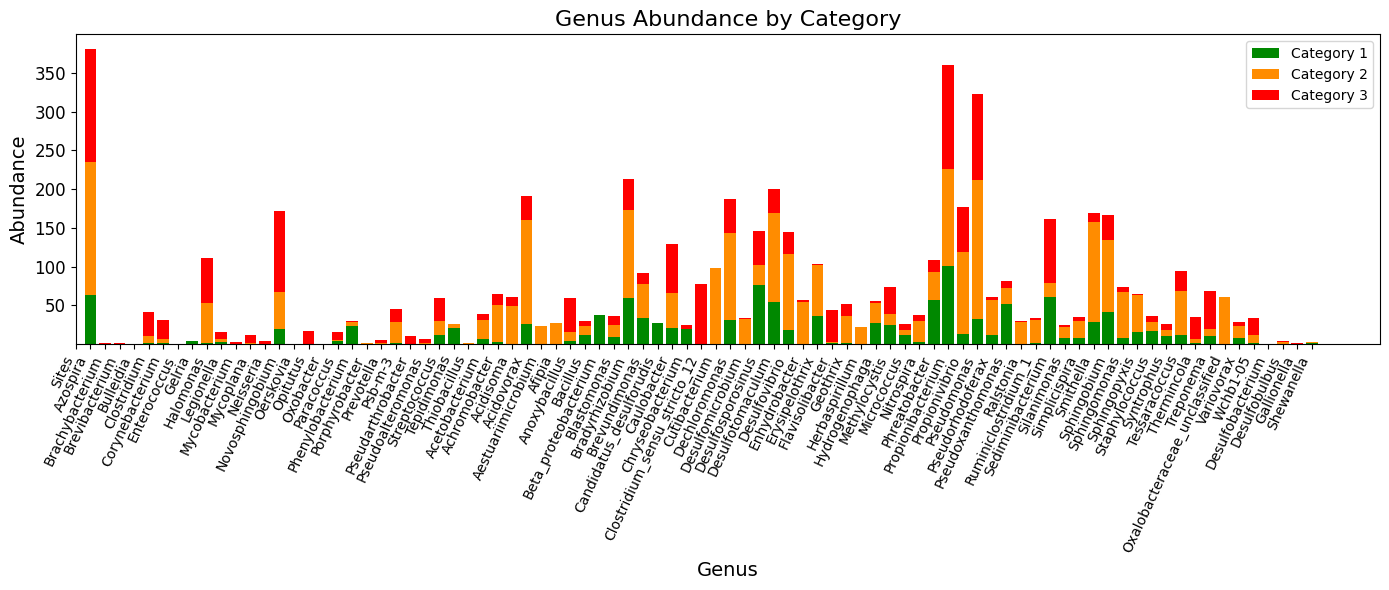

In [5]:
# Define category colors
category_colors = {
    1: '#008800',  # Green
    2: '#FF8C00',  # Orange
    3: '#FF0000'   # Red
}

def plot_genus_by_category(df, category_colors):
    """Plots stacked bars showing genus abundance by category."""

    numeric_df = df.copy()
    genera_columns = [col for col in numeric_df.columns if col != 'Category']

    # Convert genus columns to numeric, handling errors
    for col in genera_columns:
        numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

    # Group by Category and sum for each Genus
    category_genus_sums = numeric_df.groupby('Category')[genera_columns].sum()

    # Create the plot
    plt.figure(figsize=(14, 6))
    bottom = pd.Series([0] * len(genera_columns), index=genera_columns)

    for category, color in category_colors.items():
        if category in category_genus_sums.index:
            plt.bar(
                genera_columns,
                category_genus_sums.loc[category],
                bottom=bottom,
                label=f'Category {category}',
                color=color,
            )
            bottom += category_genus_sums.loc[category]

    # Add labels and formatting
    plt.title('Genus Abundance by Category', fontsize=16)
    plt.xlabel('Genus', fontsize=14)
    plt.ylabel('Abundance', fontsize=14)
    plt.xticks(rotation=65, ha='right', fontsize=10)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    # Set x-axis limits to start from 0
    plt.xlim(xmin=0)
    # Add a legend
    plt.legend()
    plt.show()

# Example usage (assuming 'integrate' is your DataFrame)
plot_genus_by_category(merged_view, category_colors)

# 7.2. Next Steps
Evidence Quality vs. Hits: The EQ scores provide better discrimination between bacteria than raw hit counts. That is because EQ scores seem to better reflect the bacteria's known importance in corrosion processes. This are brought to the study for validation purposes and would be very important on the stablishing of the hierarchi of the colonies and whole dinamic of power and dominance.
Next steps will involve the sequences finding for the genera here analysed in order to reveal evolutionary relationships that might explain shared corrosion mechanisms. This would help identify functional groups based on phylogenetic clustering, whiles providing context for the "novel" bacteria identified in the statistical analysis
In order to understand the bacterial assembly the whole of the main players would be involved, namely core_taxa, checked_genera and usual_taxa. But for the predictions analysis only the core_taya and the checked_genera would be participating, it is notice that there are important usual genera inside both groups the checked_genera and core_taxa, because of that the non abundand and ubiqus or no related to the risk label of corrosion are no taken into account on the prediction analysis. In order to make features more manageble the hierarchi, abundance and mechanisms will be analyse to make the groups engenieering the features. This will reduce noise from potential bystander species and focuses on bacteria with strong statistical or documented corrosion relationships.
Flow is as follows:
Sequencing & Phylogenetic Analysis:
Joint tree (checked + usual_suspects)
Joint tree (checked + core_taxa)

1. Phylogenetic Analysis:
- First create separate trees:
  * Core_taxa (50 high abundance)
  * Usual_suspects (known corrosion)
  * Checked_genera (statistical significance)
- Compare tree topologies
- Identify consistent clustering patterns
- Then create merged tree

2. Functional Group Analysis:
- Use PICRUSt predictions for each group separately
- Compare metabolic capabilities
- Identify functional overlaps
- Create functional groupings independent of phylogeny

3. Network Analysis:
- Create co-occurrence networks for:
  * Abundance relationships
  * Metabolic interactions
  * Phylogenetic proximity
- Identify key network nodes/hubs

4. ML Implementation:
- Feature selection based on:
  * Network centrality
  * Functional importance
  * Abundance significance
  * Phylogenetic distribution
- Use hierarchical approach:
  * First level: Core community structure
  * Second level: Corrosion-specific reA bioinformatics approach might suggest this strategy:

1. Phylogenetic Analysis:
- First create separate trees:
  * Core_taxa (50 high abundance)
  * Usual_suspects (known corrosion)
  * Checked_genera (statistical significance)
- Compare tree topologies
- Identify consistent clustering patterns
- Then create merged tree

2. Functional Group Analysis:
- Use PICRUSt predictions for each group separately
- Compare metabolic capabilities
- Identify functional overlaps
- Create functional groupings independent of phylogeny

3. Network Analysis:
- Create co-occurrence networks for:
  * Abundance relationships
  * Metabolic interactions
  * Phylogenetic proximity
- Identify key network nodes/hubs

4. ML Implementation:
- Feature selection based on:
  * Network centrality
  * Functional importance
  * Abundance significance
  * Phylogenetic distribution
- Use hierarchical approach:
  * First level: Core community structure
  * Second level: Corrosion-specific responses

In this way we will dilucidate the evolutionary relationships and it will be reveal the power dynamics, so that the community structure will be better understood.
PICRUSt Analysis:
Using combined known corrosion-causers from the three lists, will allow to undestand the mechanims that are involve so that the core_bacterias are dominating the narrative, but also if the candidate influencers bacteria are there as by standers or as potential influencing corrosion. This would allows to chose the bacteria to take moving forward towards the compendium machine learning prediction in conjunt with the physicochemical features.
By maintains independence the findings on the microbiological realm from the physicochemical, the chosing would allow for validation of the taxa and ultimately would provide an evolutionary context that links to metabolic capabilities.